In [4]:
import numpy as np
import scipy.linalg as la
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from plot_utils import *

# 1. Univariate normal

Model specification:

$$\mu\sim N(0,1)$$

$$X|\mu\sim N(\mu, 1)$$

We simulate data $X$ from $N(1, 1)$ and compare the posterior samples from SGHMC and the theoretical posterior distribution. We used a large sample size of 10000 to see the efficiency of using mini batch methods.

In [33]:
np.random.seed(2019)
data = np.random.normal(1, size = 10000)

sig2_pos = 1/(1/1 + len(data) / np.cov(data))
mean_pos = (0 + data.mean()*len(data)/np.cov(data))/(1/1 +len(data) / np.cov(data))
dist = multivariate_normal(mean_pos, (sig2_pos))
sim = dist.rvs(1000)


# Global parameters
nburnin = 500
nsample = 1000
niter = nburnin + nsample

In [34]:
# U = lambda mu: mu**2/2 + sum([(x-mu)**2/2 for x in data])
U = lambda mu: mu**2/2 + np.sum((data-mu)**2/2)
gradU = lambda mu, batch: mu + np.sum(mu-batch) * len(data) / len(batch)
Vhat = lambda mu, batch: np.cov(mu-batch)

In [35]:
def SGHMC_update_1d(Vhat, gradU, p, r, eps = 0.01, L = 100, M_i = 1):
    """
    Using leapfrog to discretalize
    
    Args:
        Vhat: empirical fisher info matrix
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """


    for i in range(L):
        p = p + eps*M_i * r
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
        V = Vhat(p, batch)
        B = 1/2 * eps * V
        C = 3
        r = r - eps*gradU(p, batch) - eps*C*M_i*r + np.random.normal(0, np.sqrt(2*(C-B)*eps))
    return p, r

In [38]:
eps = 0.0001
L = 100
nbatch= 500
np.random.seed(0)
samples = np.zeros(niter+1)
p = np.array([0.0])
samples[0] = p
for k in range(niter):
    r0 = np.random.normal(0,1)
    p, r = SGHMC_update_1d(Vhat, gradU, p, r0, eps, L)

    samples[k+1] = p
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")

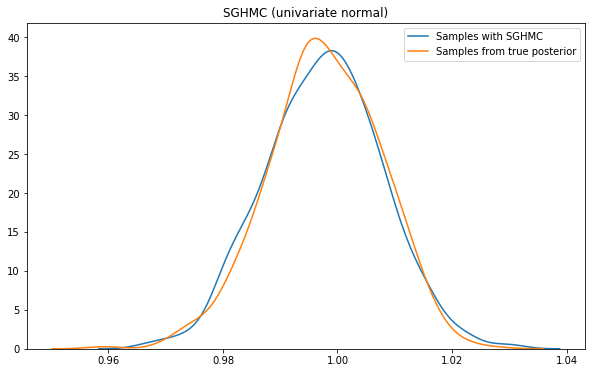

In [40]:
plt.figure(figsize=(10,6))
sns.kdeplot(samples[nburnin:], label = 'Samples with SGHMC')
sns.kdeplot(sim, label = 'Samples from true posterior')
plt.title("SGHMC (univariate normal)");
plt.savefig('SGHMC_1d.png');

# 2. Bivariate normal

Model specification:

$$\mu\sim N(\mathbf 0,\mathbf I_{2\times2})$$

$$X|\mu\sim N(\mu, \begin{bmatrix}1&0.75\\0.75&1\end{bmatrix})$$

We simulate data $X$ from $N(\begin{bmatrix}1\\-1\end{bmatrix}, \begin{bmatrix}1&0.75\\0.75&1\end{bmatrix})$ and compare the posterior samples from SGHMC and the theoretical posterior distribution. Also, we sampled 10000 data points to see the efficiency of stochastic gradient method.

In [954]:
# True parameters for generating data X (sampling distribution)
mean_or = np.array([1,-1])
sig_or = np.array([[1,0.75],[0.75,1]])
sig_or_i = la.inv(sig_or)

# Sampling distribution for generating X
np.random.seed(2019)
dist = multivariate_normal(mean_or, sig_or)
data = dist.rvs(10000)


In [955]:
# Theoretical posterior parameters and distribution
sig_pos = la.inv(len(data)*la.inv(np.cov(data.T)) + np.eye(2)) 
mean_pos = (la.inv(len(data)*la.inv(np.cov(data.T)) + np.eye(2)) @
            (len(data)*la.inv(np.cov(data.T))@np.mean(data,0) + np.eye(2)@np.zeros(2)))
post = multivariate_normal(mean_pos, sig_pos) # true posterior distribution
np.random.seed(2019)
sim = post.rvs(1000) # simulate 1000 points from posterior

In [956]:
print("True posterior mean:\n%s\n True posterior covariance:\n%s" % (mean_pos,Sig_pos))

True posterior mean:
[ 0.99883137 -0.99636525]
 True posterior covariance:
[[9.96340214e-05 7.39322499e-05]
 [7.39322499e-05 9.97459524e-05]]


### Define gradient of potential energy `gradU` and empirical fisher information matrix `Vhat`

Since we are not using Metropolis Hastings correction, so we actually don't need to define or evaluate potential energy function `U` itself.

Below I used two schemes of implementing the algorithm:

+ Use the updating steps in equation (13) in original paper, where we use `Vhat` to obtain a empirical Fisher information matrix and use it to get the estimate of random noise from using stochastic gradient method.

+ Use the equivalent updating steps in equation (15), analogous to the parameter settings as in SGD with momentum. In this (simpler as said by the authors of the paper) formation, we use learning parameter $\eta=\epsilon^2M^{-1}$, momentum decay $\alpha=\epsilon M^{-1}$. Let $\hat\beta=0$ and set $\epsilon$ to be small enough.

### Scheme 2

In [957]:
gradU = lambda mu, batch: mu - sig_or_i.dot((batch-mu).T).sum(1) / len(batch) * len(data)
Vhat = lambda mu, batch: np.cov(sig_or_i.dot((batch-mu).T))

In [959]:
def SGHMC_2d1(gradU, p, r, eps = 0.01, L = 100, M_i = np.eye(2), C = np.eye(2)):
    """
    Stochastic Gradient HMC for n-d setting
    
    Args:
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """


    for i in range(L):
        p = p + eps*M_i @ r
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
        V = Vhat(p, batch)
        B = 1/2 * eps * V
#         rr = multivariate_normal(np.zeros(len(p)), (2*(C-B)*eps))
        rr = np.random.normal(0, np.sqrt((2*(C-B)*eps)[0,0]), 2)
        r = r - eps*gradU(p,batch) - eps*C@M_i@r + rr
    return p, r

In [960]:
niter = 1100
eps = 0.00005 # stepsize
L = 100 # steps
nbatch = 500
# M_i = np.array([[1,0],[0,1]]) # M is identity matrix by default
np.random.seed(1)
samples1 = np.zeros((niter, 2))
p = np.array([0,0.0])
for k in range(niter):
    r0 = np.random.normal(0,1,2)
    p, r = SGHMC_2d1(gradU, p, r0, eps, L)

    samples1[k] = p
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")

In [961]:
print("mean of posterir samples:\n%s\n cov of posterior samples:\n%s" %
      (np.mean(samples1[nburnin:],0),np.cov(samples1[nburnin:].T)))

mean of posterir samples:
[ 0.99913013 -0.99608457]
 cov of posterior samples:
[[1.05011217e-04 7.72719214e-05]
 [7.72719214e-05 1.05462501e-04]]


In [962]:
def kde_stack(x1, y1, x2, y2, h = 6, w = 10, title=None, label=None):
    """
    Function to plot joint kde and marginals together
    """
    
    cmaps = ['Reds', 'Blues']
    g = sns.JointGrid(x=x1, y=y1)
    plt.subplots_adjust(top=0.9)
    if title != None:
        g.fig.suptitle(title)
    g.fig.set_figwidth(w)
    g.fig.set_figheight(h)
    sns.kdeplot(x1, y1, cmap=cmaps[0], ax=g.ax_joint)
    sns.kdeplot(x2, y2, cmap=cmaps[1], ax=g.ax_joint)
    
    if label != None:
        lbs = label
        label_patches = []
        label_patches.append(mpatches.Patch(color=sns.color_palette(cmaps[0])[2], label=lbs[0]))
        label_patches.append(mpatches.Patch(color=sns.color_palette(cmaps[1])[2], label=lbs[1]))
        plt.legend(handles=label_patches, loc='upper left');
    sns.distplot(x1, color="r", ax=g.ax_marg_x, hist=False, kde=True)
    sns.distplot(x2, color="b", ax=g.ax_marg_x, hist=False, kde=True)
    sns.distplot(y1, color="r", ax=g.ax_marg_y, hist=False, kde=True, vertical=True)
    sns.distplot(y2, color="b", ax=g.ax_marg_y, hist=False, kde=True, vertical=True)
    pass
    

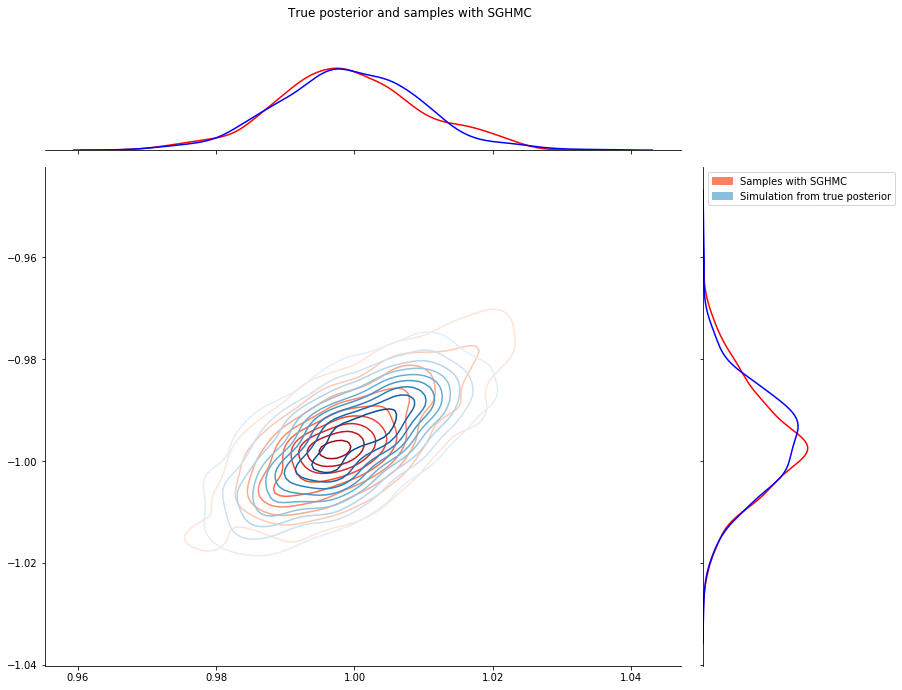

In [975]:
kde_stack(samples1[nburnin:, 0], samples1[nburnin:, 1],
          sim[:, 0], sim[:, 1],
          h=10, w=12, title= 'True posterior and samples with SGHMC',
          label=['Samples with SGHMC', 'Simulation from true posterior'])
# plt.savefig('SGHMC_2d1.png');

### Scheme 2

In [964]:
def SGHMC_2d2(gradU, p, r, alpha, eta, beta = 0, eps = 0.01, L = 100, nbatch=500):
    """
    Stochastic Gradient HMC for n-d setting
    
    Args:
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """

    v = eps * r
    for i in range(L):
        p += v
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
#         V = Vhat(p, batch)
        v = v - eta * gradU(p, batch) - alpha * v + np.random.normal(0, np.sqrt(2*(alpha-beta)*eta), len(p))
    return p, v

In [999]:
eps = 0.0001
alpha = 0.000
beta = 0.00
eta = eps**2
L = 100
nbatch= 500

samples2 = np.zeros((niter, 2))
p = np.zeros(2)
for k in range(niter):
    r0 = np.random.normal(0,1,2)
    p, r = SGHMC_2d2(gradU, p, r0, alpha, eta, beta, eps, L)

    samples2[k] = p.copy()
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")

In [1001]:
print("mean of posterir samples:\n%s\n cov of posterior samples:\n%s" %
      (np.mean(samples2[nburnin+1:],0),np.cov(samples2[nburnin+1:].T)))

mean of posterir samples:
[ 1.00096537 -0.99444862]
 cov of posterior samples:
[[9.45078725e-05 6.07279698e-05]
 [6.07279698e-05 8.90230707e-05]]


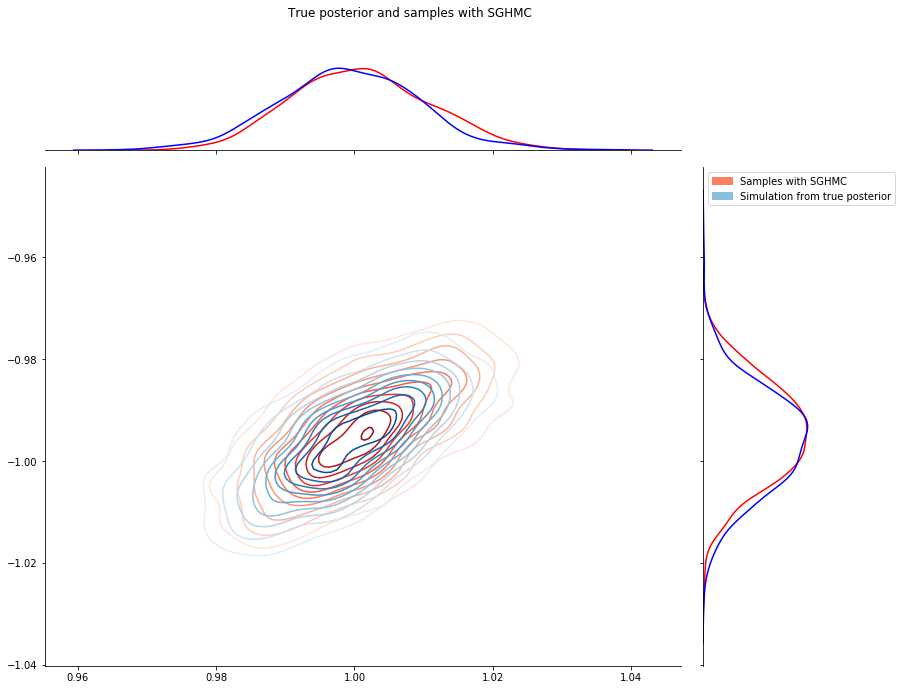

In [1003]:
kde_stack(samples2[nburnin+1:, 0], samples2[nburnin+1:, 1],
          sim[:, 0], sim[:, 1],
          h=10, w=12, title= 'True posterior and samples with SGHMC',
          label=['Samples with SGHMC', 'Simulation from true posterior'])
plt.savefig('SGHMC_2d2.png');

In [1]:
%%file SGHMC_sim.py

import numpy as np
import scipy.linalg as la
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from plot_utils import *

#############################
### 1. Univariate normal  ###
#############################

np.random.seed(2019)
data = np.random.normal(1, size = 10000)

sig2_pos = 1/(1/1 + len(data) / np.cov(data))
mean_pos = (0 + data.mean()*len(data)/np.cov(data))/(1/1 +len(data) / np.cov(data))
dist = multivariate_normal(mean_pos, (sig2_pos))
sim = dist.rvs(1000)


# Global parameters
nburnin = 100
nsample = 1000
niter = nburnin + nsample


# U = lambda mu: mu**2/2 + sum([(x-mu)**2/2 for x in data])
U = lambda mu: mu**2/2 + np.sum((data-mu)**2/2)
gradU = lambda mu, batch: mu + np.sum(mu-batch) * len(data) / len(batch)
Vhat = lambda mu, batch: np.cov(mu-batch)



def SGHMC_update_1d(Vhat, gradU, p, r, eps = 0.01, L = 100, M_i = 1):
    """
    Using leapfrog to discretalize
    
    Args:
        Vhat: empirical fisher info matrix
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """


    for i in range(L):
        p = p + eps*M_i * r
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
        V = Vhat(p, batch)
        B = 1/2 * eps * V
        C = 3
        r = r - eps*gradU(p, batch) - eps*C*M_i*r + np.random.normal(0, np.sqrt(2*(C-B)*eps))
    return p, r



niter = 1100
eps = 0.0001
L = 100
nbatch= 500
np.random.seed(2019)
samples = np.zeros(niter+1)
p = np.array([0.0])
samples[0] = p
for k in range(niter):
    r0 = np.random.normal(0,1)
    p, r = SGHMC_update2(Vhat, gradU, p, r0, eps, L)

    samples[k+1] = p
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")
    
    
plt.figure(figsize=(10,6))
sns.kdeplot(samples[100:], label = 'Samples with SGHMC')
sns.kdeplot(sim, label = 'Samples with HMC')
plt.title("SGHMC (univariate normal)");
# plt.savefig('SGHMC_1d.png');



#############################
### 2. Bivariate normal #####
#############################

# True parameters for generating data X (sampling distribution)
mean_or = np.array([1,-1])
sig_or = np.array([[1,0.75],[0.75,1]])
sig_or_i = la.inv(sig_or)

# Sampling distribution for generating X
np.random.seed(2019)
dist = multivariate_normal(mean_or, sig_or)
data = dist.rvs(10000)


# Theoretical posterior parameters and distribution
sig_pos = la.inv(len(data)*la.inv(np.cov(data.T)) + np.eye(2)) 
mean_pos = (la.inv(len(data)*la.inv(np.cov(data.T)) + np.eye(2)) @
            (len(data)*la.inv(np.cov(data.T))@np.mean(data,0) + np.eye(2)@np.zeros(2)))
post = multivariate_normal(mean_pos, sig_pos) # true posterior distribution
np.random.seed(2019)
sim = post.rvs(1000) # simulate 1000 points from posterior

print("True posterior mean:\n%s\n True posterior covariance:\n%s" % (mean_pos,Sig_pos))


#############################
### 2.1 sampling scheme 1 ###
#############################

gradU = lambda mu, batch: mu - sig_or_i.dot((batch-mu).T).sum(1) / len(batch) * len(data)
Vhat = lambda mu, batch: np.cov(sig_or_i.dot((batch-mu).T))

def SGHMC_2d1(gradU, p, r, eps = 0.01, L = 100, M_i = np.eye(2), C = np.eye(2)):
    """
    Stochastic Gradient HMC for n-d setting
    
    Args:
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """


    for i in range(L):
        p = p + eps*M_i @ r
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
        V = Vhat(p, batch)
        B = 1/2 * eps * V
#         rr = multivariate_normal(np.zeros(len(p)), (2*(C-B)*eps))
        rr = np.random.normal(0, np.sqrt((2*(C-B)*eps)[0,0]), 2)
        r = r - eps*gradU(p,batch) - eps*C@M_i@r + rr
    return p, r


niter = 1100
eps = 0.00005 # stepsize
L = 100 # steps
nbatch = 500
# M_i = np.array([[1,0],[0,1]]) # M is identity matrix by default
np.random.seed(1)
samples1 = np.zeros((niter, 2))
p = np.array([0,0.0])
for k in range(niter):
    r0 = np.random.normal(0,1,2)
    p, r = SGHMC_2d1(gradU, p, r0, eps, L)

    samples1[k] = p
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")
    
    
print("mean of posterir samples:\n%s\n cov of posterior samples:\n%s" %
      (np.mean(samples1[nburnin:],0),np.cov(samples1[nburnin:].T)))


kde_stack(samples1[nburnin:, 0], samples1[nburnin:, 1],
          sim[:, 0], sim[:, 1],
          h=10, w=12, title= 'True posterior and samples with SGHMC',
          label=['Samples with SGHMC', 'Simulation from true posterior'])
# plt.savefig('SGHMC_2d1.png');


#############################
### 2.2 sampling scheme 2 ###
#############################


def SGHMC_2d2(gradU, p, r, alpha, eta, beta = 0, eps = 0.01, L = 100, nbatch=500):
    """
    Stochastic Gradient HMC for n-d setting
    
    Args:
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """

    v = eps * r
    for i in range(L):
        p += v
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
#         V = Vhat(p, batch)
        v = v - eta * gradU(p, batch) - alpha * v + np.random.normal(0, np.sqrt(2*(alpha-beta)*eta), len(p))
    return p, v


eps = 0.0001
alpha = 0.000
beta = 0.00
eta = eps**2
L = 100
nbatch= 500

samples2 = np.zeros((niter, 2))
p = np.zeros(2)
for k in range(niter):
    r0 = np.random.normal(0,1,2)
    p, r = SGHMC_2d2(gradU, p, r0, alpha, eta, beta, eps, L)

    samples2[k] = p.copy()
    print("%.2f %%" % np.round((k+1)/niter*100,2), end = "\r")
    
    
print("mean of posterir samples:\n%s\n cov of posterior samples:\n%s" %
      (np.mean(samples2[nburnin+1:],0),np.cov(samples2[nburnin+1:].T)))


kde_stack(samples2[nburnin+1:, 0], samples2[nburnin+1:, 1],
          sim[:, 0], sim[:, 1],
          h=10, w=12, title= 'True posterior and samples with SGHMC',
          label=['Samples with SGHMC', 'Simulation from true posterior'])
plt.savefig('SGHMC_2d2.png');

Writing SGHMC_sim.py
